In [1]:
import glob, os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from __future__ import print_function

import tensorflow as tf

from keras.layers import Flatten, Dense, Reshape
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras import losses
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras import models
from keras import layers
import keras

from sklearn.utils import shuffle
from sklearn import preprocessing
import scipy.io
from mpl_toolkits.mplot3d import Axes3D



import numpy as np
import pandas as pd
import sys
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn import preprocessing
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
#from keract import get_activations
import numpy as np 
import pandas as pd 
from tensorflow import keras
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras import losses
import numpy as np
import os, glob

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
def pairwise_dist(A):
    # Taken frmo https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)
    r = tf.reshape(r, [-1, 1])
    D = tf.maximum(r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r), 1e-7)
    D = tf.sqrt(D)
    return D

def dist_corr(X, Y):
    n = tf.cast(tf.shape(X)[0], tf.float32)
    a = pairwise_dist(X)
    b = pairwise_dist(Y)
    A = a - tf.reduce_mean(a, axis=1) - tf.expand_dims(tf.reduce_mean(a, axis=0), axis=1) + tf.reduce_mean(a)
    B = b - tf.reduce_mean(b, axis=1) - tf.expand_dims(tf.reduce_mean(b, axis=0), axis=1) + tf.reduce_mean(b)
    dCovXY = tf.sqrt(tf.reduce_sum(A*B) / (n ** 2))
    dVarXX = tf.sqrt(tf.reduce_sum(A*A) / (n ** 2))
    dVarYY = tf.sqrt(tf.reduce_sum(B*B) / (n ** 2))
    
    dCorXY = dCovXY / tf.sqrt(dVarXX * dVarYY)
    return dCorXY

def custom_loss1(y_true,y_pred):
    dcor = dist_corr(y_true,y_pred)
    return dcor

def custom_loss2(y_true,y_pred):
    recon_loss = losses.categorical_crossentropy(y_true, y_pred)
    return recon_loss

In [4]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [5]:
DATA_DIR = "./UTKFace/"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

In [6]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df = df[(df['age'] > 10) & (df['age'] < 65)]

df.head()

./UTKFace/61_1_20170109142408075.jpg.chip.jpg
./UTKFace/39_1_20170116174525125.jpg.chip.jpg
./UTKFace/61_1_20170109150557335.jpg.chip.jpg


,age,gender,race,file
1,61.0,male,white,./UTKFace/61_0_0_20170117193447568.jpg.chip.jpg
4,32.0,female,black,./UTKFace/32_1_1_20170115235041750.jpg.chip.jpg
5,20.0,male,white,./UTKFace/20_0_0_20170116201311689.jpg.chip.jpg
7,53.0,male,indian,./UTKFace/53_0_3_20170119205931304.jpg.chip.jpg
8,45.0,female,black,./UTKFace/45_1_1_20170116003204136.jpg.chip.jpg


In [7]:
p = np.random.RandomState(10).permutation(len(df))
print(p)
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

[15086  9370   344 ... 17728  7293 17673]


(9079, 3891, 5559, 64.0)

In [8]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                images = np.array(images)
                #flattened_images = np.reshape(images, (-1, IM_HEIGHT * IM_WIDTH * 3))
                yield images, [np.array(races), np.array(ages), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [9]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

from keras import losses
import numpy as np
import os

# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = False

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

input_shape = (IM_HEIGHT, IM_WIDTH, 3)

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=10):
    #def custom_loss1(y_true,y_pred):
    #    dcor = 1 * distance_correlation(y_true,splitLayer)
    #    return dcor

    #def custom_loss2(y_true,y_pred):
    #    recon_loss = losses.categorical_crossentropy(y_true, y_pred)
    #    return recon_loss
    """ResNet Version 2 Model builder [b]
    
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    Experiment for UTKFace -
    fmap initial size -
    conv1: 198x198x3
    conv2: 99x99x3
    conv3: 49x49x16
    conv4: 24x24x64
    stage 0: 24x24x64
    stage 1: 12x12x128
    stage 2: 6x6x256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    conv1 = Conv2D(3,
                  kernel_size=5,
                  strides=2,
                  padding='valid',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    conv2 = Conv2D(3,
                   kernel_size=5,
                   strides=2,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))
    conv3 = Conv2D(16,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    conv4 = Conv2D(filters = 64,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    z1 = conv1(inputs)
    #before_flatten_dims = z1.get_shape().as_list()[1:]
    #before_flatten_dims[0] = -1
    #print(before_flatten_dims)
    #split_layer = Flatten(name='split_layer')(z1)
    #reshaped = Reshape(before_flatten_dims)(split_layer)
    #print(reshaped)
    z2 = conv2(z1)
    z3 = conv3(z2)
    z4 = conv4(z3)
    #print(z3)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=z3,
                     num_filters=num_filters_in,
                     conv_first=True)
    #print(x)
    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            if stage == 2 and res_block == 2:
                before_flatten_dims = x.get_shape().as_list()[1:]
                split_layer = Flatten(name='split_layer')(x)
                x = Reshape(before_flatten_dims)(split_layer)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out
    print(x)
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=6)(x)
    x = Flatten()(x)
    x = Dense(100,
              activation='relu',
              kernel_initializer='he_normal')(x)

    # for race prediction
    # race = Dense(units=128, activation='relu')(x)
    # race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(race)
    age = Dense(units=128, activation='relu')(x)
    age_output = Dense(units=1, activation='sigmoid', name='age_output')(age)

    # for gender prediction
    gender = Dense(units=128, activation='relu')(x)
    gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(gender)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=[split_layer, age_output, gender_output])
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)


W0214 03:52:28.034432 139820065445696 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4074: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



Tensor("add_9/add:0", shape=(?, 7, 7, 256), dtype=float32)


In [10]:
alpha1, alpha2 = 0.9999, 0.0001
experiment_name = "{}-{}-UTKFace-age-attribute".format(alpha1, alpha2)

model.compile(loss={'age_output': 'mse', 'gender_output': 'categorical_crossentropy',
                    'split_layer': custom_loss1},
              loss_weights={'split_layer':alpha1, 'age_output':alpha2, 'gender_output':alpha2},
              optimizer=Adam(lr=lr_schedule(0)),
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

# Prepare model model saving directory.
#filepath = os.path.join(save_dir, model_name)



lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

#callbacks = [checkpoint, lr_reducer, lr_scheduler]


from keras.callbacks import ModelCheckpoint


train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=batch_size)

callbacks = [
    ModelCheckpoint("./saved_models/{}_{}_age_attribute_model.h5".format(alpha1,alpha2), monitor='val_loss'),
    lr_reducer, lr_scheduler
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=200,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//batch_size,
                             verbose=2)

Learning rate:  0.001


W0214 03:53:19.411648 139820065445696 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0214 03:53:36.909154 139820065445696 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/200
Learning rate:  0.001
 - 68s - loss: 0.5706 - split_layer_loss: 0.2986 - age_output_loss: 0.0372 - gender_output_loss: 0.6760 - age_output_mae: 0.1580 - gender_output_accuracy: 0.5780 - val_loss: 0.6278 - val_split_layer_loss: 0.2931 - val_age_output_loss: 0.0354 - val_gender_output_loss: 0.6681 - val_age_output_mae: 0.1522 - val_gender_output_accuracy: 0.6082
Epoch 2/200
Learning rate:  0.001
 - 48s - loss: 0.4031 - split_layer_loss: 0.2725 - age_output_loss: 0.0372 - gender_output_loss: 0.6863 - age_output_mae: 0.1581 - gender_output_accuracy: 0.5547 - val_loss: 0.4998 - val_split_layer_loss: 0.3830 - val_age_output_loss: 0.0362 - val_gender_output_loss: 0.6903 - val_age_output_mae: 0.1481 - val_gender_output_accuracy: 0.5550
Epoch 3/200
Learning rate:  0.001
 - 48s - loss: 0.3809 - split_layer_loss: 0.2629 - age_output_loss: 0.0370 - gender_output_loss: 0.6903 - age_output_mae: 0.1576 - gender_output_accuracy: 0.5338 - val_loss: 0.4174 - val_split_layer_loss: 0.3002 - va

KeyboardInterrupt: 

In [11]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    """axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()"""
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()
    """
    axes[2].plot(history.history['age_output_mae'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_mae'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()"""
    
    axes[2].plot(history.history['split_layer_loss'], label='Split Layer loss')
    axes[2].plot(history.history['val_split_layer_loss'], label='Split Val loss')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()
    
    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

NameError: name 'history' is not defined

In [12]:
len(train_idx)

9079

In [13]:
len(valid_idx)

3891

In [ ]:
#import keras
#import keras_resnet.models
#shape, classes = (32, 32, 3), 10
#x = keras.layers.Input(shape)
#model = keras_resnet.models.ResNet50(x, classes=classes)
#model.compile("adam", "categorical_crossentropy", ["accuracy"])
#(training_x, training_y), (_, _) = keras.datasets.cifar10.load_data()
#training_y = keras.utils.np_utils.to_categorical(training_y)
#model.fit(training_x, training_y)
#model.layers.pop()
#model.summary()

In [67]:
from keras.models import load_model
#alpha1, alpha2 = 0.2, 4.0
model = load_model('./saved_models/{}_{}_weighted_VGG_model.h5'.format(alpha1, alpha2),
                   custom_objects={'custom_loss1': custom_loss1})

(None, None)


In [11]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{'age_output_loss': 0.02511364407837391,
 'age_output_mae': 0.11955787986516953,
 'gender_output_accuracy': 0.9140625,
 'gender_output_loss': 0.28933125734329224,
 'loss': 0.3328768014907837,
 'split_layer_loss': 0.4000818431377411}

In [62]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{'loss': 3.2583343982696533,
 'split_layer_loss': -2.218268394470215,
 'age_output_loss': 0.030641425400972366,
 'race_output_loss': 2.5436744689941406,
 'gender_output_loss': 0.8520989418029785,
 'age_output_mae': 0.13043132424354553,
 'race_output_accuracy': 0.7434592843055725,
 'gender_output_accuracy': 0.9222383499145508}

In [11]:
Z_HEIGHT = Z_WIDTH = 7
x_test_encoded = np.random.randn(0, Z_HEIGHT, Z_WIDTH, 256)
x_raw = np.random.randn(0, IM_HEIGHT, IM_WIDTH, 3)
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
labels = [np.zeros((0, 5)), np.zeros((0,)), np.zeros((0, 2))]

for test_data_batch in test_gen:
    labels[0] = np.concatenate((labels[0], test_data_batch[1][0]))
    labels[1] = np.concatenate((labels[1], test_data_batch[1][1]))
    labels[2] = np.concatenate((labels[2], test_data_batch[1][2]))
    test_prediction = model.predict(test_data_batch[0])
    x_raw = np.concatenate((x_raw, test_data_batch[0]))
    x_test_encoded = np.concatenate((x_test_encoded, test_prediction[0].reshape(-1, Z_HEIGHT, Z_WIDTH, 256)))

W0210 22:14:38.257375 140064449984320 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0210 22:14:38.319938 140064449984320 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0210 22:14:38.388659 140064449984320 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0210 22:14:38.973876 140064449984320 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0210 22:14:39.037262 140064449984320 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0210 22:14:39.091355 140064449984320 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0210 22:14:39.153309 140064

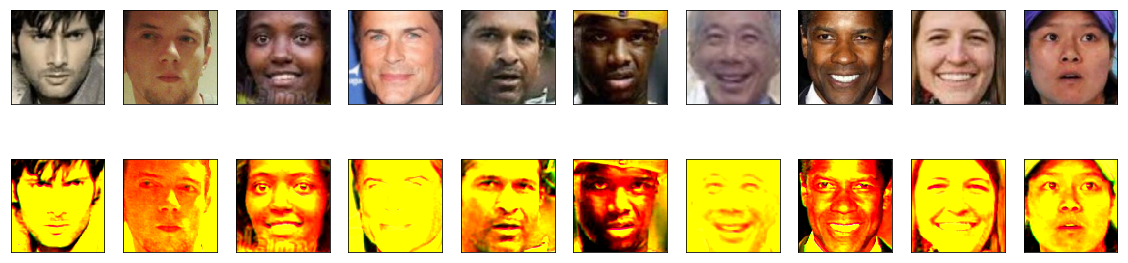

In [13]:
#test raw vs smash
n = 20
plt.figure(figsize=(40, 5))
for i in range(10,20):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_raw[i])
    #plt.imshow((x_test[i] * 255).astype(np.int64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_encoded[i].reshape(Z_HEIGHT, Z_WIDTH, 3))
    #plt.imshow((x_test_encoded[0][i].reshape(32, 32, 3) * 255).astype(np.int64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [38]:
labels[1][26]

0.171875

In [12]:
import os
experiment_name = "UTKFace_race_0.9999_0.0001_2_2".format(alpha1, alpha2)
out_dir = './datasets/{}/output/'.format(experiment_name)
inp_dir = './datasets/{}/input/'.format(experiment_name)
os.makedirs(out_dir)
os.makedirs(inp_dir)
for i in range(x_raw.shape[0]):
    #np.save('rawCifar10_baseline/'+str(i), x_test[i],allow_pickle = True)
    #np.save('noSmashCifar10_baseline/'+str(i), x_test_encoded[0][i].reshape(32, 32, 3),allow_pickle = True)
    np.save('{}/{}_{}_{}'.format(out_dir, i, labels[0][i].argmax(),
                                    labels[2][i].argmax()), x_test_encoded[i].reshape(7, 7, 256), allow_pickle = True)
    np.save('{}/{}'.format(inp_dir, i), x_raw[i].reshape(IM_HEIGHT, IM_WIDTH, 3), allow_pickle = True)

    #matplotlib.image.imsave('rawCifar10/'+str(i)+'.png', x_test[i])
    #matplotlib.image.imsave('smashCifar10/'+str(i)+'.png', x_test_encoded[0][i].reshape(32, 32, 3))

In [42]:
import pickle

with open('./saved_models/{}'.format(experiment_name), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

NameError: name 'history' is not defined

NameError: name 'x_train' is not defined

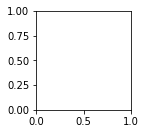

In [43]:
#train raw vs smash
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_encoded[0][i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
#Uncomment and use below to get activations. Also try to get for particual layer at a time via book, instead of enumerating all.
#from keract import get_activations
#activations = get_activations(model, x_test[1:2])
#from keract import display_activations
#display_activations(activations, cmap="gray", save=False)

In [ ]:
x_test_encoded[0][1].shape

In [ ]:
x_testRaw.shape

In [44]:
print(experiment_name)

1000.0-0.1-UTKFace-race-attribute-layer4


In [45]:
labels[0][0]

array([0., 0., 1., 0., 0.])